importing Jupyter notebook from pytorchtools.ipynb
importing Jupyter notebook from utils.ipynb
[1/1] train_loss: 0.22847 valid_loss: 0.22114
Validation loss decreased (inf --> 0.221140).  Saving model ...


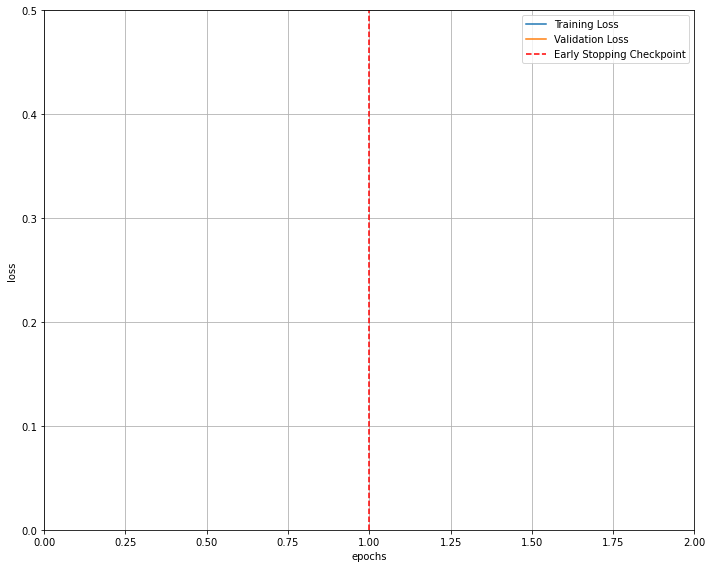

Starting test
Test loader created
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Running batch
Test Accuracy of the model on the 10000 test images: 97.89999999999999 %
Confusion matrix, without normalization
(array([[ 971,    0,    6,    2,    1,    2,    5,    0,   11,    3],
       [   0, 1129,    1,    0,    0,    0,    3,    2,    1,    4],
       [   0,    1, 1014,    1,    2,    0,    0,    7,    6,    0],
       [   0,    2,    3,  989,    0,    3,    1,    4,    3,    3],
       [   0,   

TypeError: Image data of dtype object cannot be converted to float

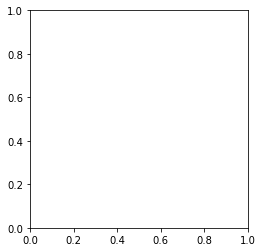

In [2]:
"""
CNN with early stopping
"""
import import_ipynb # if the import causes issues, make sure the module is installed with pip install import_ipynb
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import copy
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import json
from pytorchtools import EarlyStopping
from torch.utils.data.sampler import SubsetRandomSampler
from pytorchtools import EarlyStopping
from torchvision import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import utils

##############################################################################
########################## CREATING DATASETS #################################
##############################################################################
def create_datasets(batch_size):
    # Method adapted from: 
    # https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root='cnn2data', 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root='cnn2data',
                               train=False,
                               download=True,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

##############################################################################
############################# DEFINING MODEL #################################
##############################################################################

class ConvNet1(nn.Module):
    # Adapted from
    # https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/
    def __init__(self):
        super(ConvNet1, self).__init__()
        #  First, we create layer 1 (self.layer1) by creating a nn.Sequential object. 
        # This method allows us to create sequentially ordered layers in our network 
        # and is a handy way of creating a convolution + ReLU + pooling sequence.
        self.layer1 = nn.Sequential(
            # Conv2d creates a set of convolutional filters.
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
        
##############################################################################
################## DEFINING TRAIN AND TEST METHODS ###########################
##############################################################################
def train(model, train_loader, valid_loader, num_epochs = 5,
          batch_size = 100, learning_rate = 0.001, patience = 20):
    # Code (only) for early stopping adapted from:
    # https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb 

    model.criterion = nn.CrossEntropyLoss()

    # specify optimizer
    model.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    #self.initialize_data(DATA_PATH) # where to save data
    model.batch_size = batch_size
    
    ### WITH EARLY STOPPING
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, num_epochs + 1):
        
        for i, (images, labels) in enumerate(train_loader):
            
            ## TRAINING ##
            # Run the forward pass
            outputs = model.forward(images)
            loss = model.criterion(outputs, labels)
            
            # Backprop and perform Adam optimisation
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()
            
            train_losses.append(loss.item())
            
            ## VALIDATING ##
            model.eval()
            for data, labels in valid_loader:
                output = model.forward(data)
                loss = model.criterion(output, labels)
                valid_losses.append(loss.item())
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(num_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses #model, avg_train_losses, avg_valid_losses
                

def test(model, test_loader):
        print("Starting test")
        print("Test loader created")
        
        # Storing labels and predicted for the purpose of making confusion matrix
        all_labels = []
        all_predicted = []

        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                all_labels.append(labels)
                print("Running batch")
                # train is being called when test() is run, so I'm amending the code below to see if it has any effects
                outputs = model.forward(images) # model(images)
                target, predicted = torch.max(outputs.data, 1)
                all_predicted.append(predicted)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            test_accuracy = (correct / total) * 100
            print('Test Accuracy of the model on the 10000 test images: {} %'.format(test_accuracy))
            return test_accuracy, all_predicted, all_labels
        

##############################################################################
############################## CALLING THE METHODS ###########################
##############################################################################

##### CALLING THE MODEL
model = ConvNet1() 

batch_size = 256
n_epochs = 1
patience = 20 # BEST: 20
activation_func = "relu"
learningrate = 0.001
train_loader, test_loader, valid_loader = create_datasets(batch_size)

model, train_loss, valid_loss = train(model,
    train_loader=train_loader, valid_loader=valid_loader, num_epochs = n_epochs,
    batch_size=batch_size, learning_rate=learningrate, patience=patience) 

##### PLOTTING TRAINING AND VALIDATION LOSS AGAINST EPOCHS
# Source: https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

##### TESTING THE MODEL
test_accuracy, all_predicted, all_labels = test(model, test_loader)
#experiment_no = 10

##### MAKING AND PLOTTING CONFUSION MATRIX
confus_matrix = utils.generate_confusion_matrix(all_predicted, all_labels)
#utils.plot_confusion_matrix(confus_matrix, [0,1,2,3,4,5,6,7,8,9])


##### Recording model spec and performance
#model_specs = {
#    "Experiment" : str(experiment_no),
#    "Test_accuracy" : [test_accuracy],
#    "Patience" : [patience],
#    "Epochs" : [n_epochs],
#    "Batch_size" : [batch_size],
#    "Model_spec" : [model],
#    "Activation_func" : [activation_func],
#    "Optimizer" : [model.optimizer],
#    "Loss func" : [model.criterion]
#    
#    }
#results_df = pd.DataFrame.from_dict(data=model_specs)
#all_results = all_results.append(results_df)
#experiment_no += 1 
#all_results.to_excel("all_results_task3.xlsx")


Confusion matrix, without normalization
(array([[ 971,    0,    6,    2,    1,    2,    5,    0,   11,    3],
       [   0, 1129,    1,    0,    0,    0,    3,    2,    1,    4],
       [   0,    1, 1014,    1,    2,    0,    0,    7,    6,    0],
       [   0,    2,    3,  989,    0,    3,    1,    4,    3,    3],
       [   0,    0,    1,    0,  943,    0,    1,    0,    2,    1],
       [   2,    0,    0,    9,    0,  883,    5,    0,    5,    3],
       [   3,    1,    0,    0,    1,    1,  943,    0,    0,    0],
       [   1,    1,    7,    4,    0,    1,    0,  993,    1,    1],
       [   2,    1,    0,    1,    2,    0,    0,    1,  931,    0],
       [   1,    0,    0,    4,   33,    2,    0,   21,   14,  994]],
      dtype=int64), tensor([7, 2, 1,  ..., 4, 5, 6]), tensor([7, 2, 1,  ..., 4, 5, 6]))


TypeError: Image data of dtype object cannot be converted to float

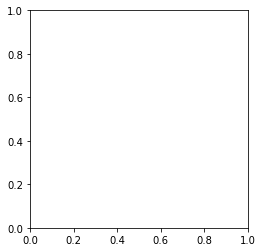

In [4]:
utils.plot_confusion_matrix(confus_matrix, [0,1,2,3,4,5,6,7,8,9])